<a href="https://colab.research.google.com/github/cc-ats/mlp_tutorial/blob/main/Lesson2_GPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process Regression Models

## Defining the Mueller-Brown Potential Energy Surface

For the definition of Mueller-Brown potential, see [here](https://www.wolframcloud.com/objects/demonstrations/TrajectoriesOnTheMullerBrownPotentialEnergySurface-source.nb).

In this tutorial, we will learn how to use a Gaussian Process Regression model to predict the energy and gradient of points on the Mueller-Brown potential energy surface.

We will start by defining the function for the Mueller-Brown potential energy surface:

$v(x,y) = \sum_{k=0}^3 A_k \mathrm{exp}\left[ a_k (x - x_k^0)^2 + b_k (x - x_k^0) (y - y_k^0) + c_k (y - y_k^0)^2 \right]$

We will also define the derivatives with respect to $x$ and $y$ for the Muller-Brown potential energy surface:

$\frac{dv(x,y)}{dx}  = \sum_{k=0}^3 A_k \mathrm{exp}\left[ a_k (x - x_k^0)^2 + b_k (x - x_k^0) (y - y_k^0) + c_k (y - y_k^0)^2 \right]\left [2a_k (x - x_k^0)+b_k(y - y_k^0) \right]$

$\frac{dv(x,y)}{dy}  = \sum_{k=0}^3 A_k \mathrm{exp}\left[ a_k (x - x_k^0)^2 + b_k (x - x_k^0) (y - y_k^0) + c_k (y - y_k^0)^2 \right]\left [b_k(x - x_k^0)+ 2 c_k(y - y_k^0) \right]$


In [1]:
from math import exp, pow, tanh
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
def mueller_brown_potential(x, y):
  A = [-200, -100, -170, 15]
  a = [-1, -1, -6.5, 0.7]
  b = [0, 0, 11, 0.6]
  c = [-10, -10, -6.5, 0.7]
  x0 = [1, 0, -0.5, -1.0]
  y0 = [0, 0.5, 1.5, 1]
  value = 0
  dx_value = 0
  dy_value = 0
  for k in range(0, 4):
    value += 0.1 * A[k] * exp( a[k] * pow(x-x0[k], 2.0) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2.0))
    dx_value += 0.1 * A[k] * exp( a[k] * pow(x-x0[k], 2.0) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2.0)) * (a[k]*2.0*(x-x0[k]) + b[k] * (y-y0[k]))
    dy_value += 0.1 * A[k] * exp( a[k] * pow(x-x0[k], 2.0) + b[k] * (x-x0[k]) * (y-y0[k]) + c[k] * pow(y-y0[k], 2.0)) * (b[k] * (x-x0[k])+ c[k]*2.0* (y-y0[k]))
  return value, dx_value, dy_value

### Generating Training Data

First, we need to generate data to train the neural network, as done previously in Lesson 1. Displayed below are the max/min values of the surface and the size of the training and testing sets.

In [3]:
xx = np.arange(-1.8, 1.4, 0.1)
yy = np.arange(-0.4, 2.4, 0.1)
X, Y = np.meshgrid(xx, yy)
xy, xy_truncated = [],[]
z, z_truncated = [], []
dx, dx_truncated = [], []
dy, dy_truncated = [], []
for y in yy:
  for x in xx:
    v, dvx, dvy = mueller_brown_potential(x,y)
    z.append(v)
    dx.append(dvx)
    dy.append(dvy)
    xy.append([x,y])
    if v < 10:  #keep only low-energy points for ML training
      xy_truncated.append([x, y])
      z_truncated.append(v)
      dx_truncated.append(dvx)
      dy_truncated.append(dvy)
Z = np.reshape(z,(len(yy),-1))
DX = np.reshape(dx,(len(yy),-1))
DY = np.reshape(dy,(len(yy),-1))
print("Zmin:", np.amin(Z), "Zmax:", np.amax(Z))
print("Size of Testing set:", len(z))
print("Size of (future) training set:", len(z_truncated))

x_truncated=[]
y_truncated=[]
for i in range(len(xy_truncated)):
  x_truncated.append(xy_truncated[i][0])
  y_truncated.append(xy_truncated[i][1])
x_ref, y_ref = np.meshgrid(x_truncated, y_truncated)
z_ref= np.reshape(z_truncated,(len(y_truncated),-1))

Zmin: -14.599803525171698 Zmax: 1194.4772333054245
Size of Testing set: 896
Size of (future) training set: 696


### Visualizing Training Data: 3-D Projection Surface

We will now create a 3-D plot of our training data. To make the plot more readable, we will replace the points that have extremely high energy with nan (not a number). This will keep our $Z$ array the same shape and help us ignore the high energy region that we are not interested in.

In [4]:
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='rainbow', cmin=-15, cmax=9)])
fig.update_traces(contours_z=dict(show=True, project_z=True))
fig.update_layout(title='Mueller-Brown Potential', width=500, height=500,
                  scene = dict(
                      zaxis = dict(dtick=3, range=[-15, 15]),
                      camera_eye = dict(x=-1.2, y=-1.2, z=1.2)))
fig.show()

### Visualizing Training Data: 3-D Projection Surface

Because we are keeping only the low energy points for training (v$<$10, see [2.1.1]), we will make a 3-D surface plot that more accurately reflects our training data.


In [5]:
import copy

clean_Z = copy.copy(Z)
clean_Z[clean_Z>10] = np.nan

fig = go.Figure(data=[go.Surface(z=clean_Z, x=X, y=Y, colorscale='rainbow', cmin=-15, cmax=9)])
fig.update_traces(contours_z=dict(show=True, project_z=True))
fig.update_layout(title='Mueller-Brown Potential', width=500, height=500,
                  scene = dict(
                      zaxis = dict(dtick=3, range=[-15, 15]),
                      camera_eye = dict(x=-1.2, y=-1.2, z=1.2)))
fig.show()

### Visualizing Training Data: Contour Surface

To allow for an easier visualization of the potential energy surface, we can generate a 2-D contour surface.

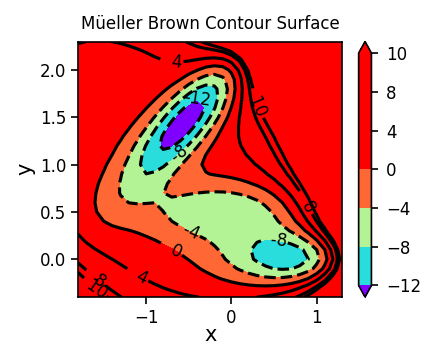

In [6]:
fig = plt.figure(figsize=(3,2.5), dpi=150)
levels = [-12, -8, -4, 0, 4, 8, 10]
ct = plt.contour(X, Y, Z, levels, colors='k')
plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
plt.xlabel("x", labelpad=-0.75)
plt.ylabel("y", labelpad=2.5)
plt.tick_params(axis='both', pad=2,labelsize=8)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=8)
plt.title('Müeller Brown Contour Surface', fontsize=8)
plt.tight_layout()
plt.show()

## Loading PyTorch and GPyTorch for GPR Learning

Now we will install GPyTorch.

In [7]:
%%capture
!pip install gpytorch

import numpy as np
import torch
import gpytorch
from torch import Tensor

## Defining a GPR Model for Energy Prediction

First, we will learn how to use a GPR model to predict energies only.

Let us define the variables in our function using a vector of input features with $D$ observables as $\textbf{x}=[x_1,...,x_D]$. A set of $n$ configurations can be assembled into a training set $\textbf{X}=[\textbf{x}_1, ...,\textbf{x}_n]$ with a corresponding set of observations $\textbf{y}=[y_1,...,y_n]^T$.

For noisy samples, we can assume that an observation $y$ is seperate from the underlying function $f(\textbf{x})$ according to $y(\textbf{x})=f(\textbf{x})+\mathit{ε}$, where the noise, $\mathit{ε}$, follows a Gaussian distribution $\mathit{ε}\sim\mathcal{N}(0,σ^2_n)$, where $\sigma^2_n$ is the noise parameter. The prior distribution of underlying functions follows a Gaussian distribution $\textbf{f}(\textbf{X})\sim\mathcal{N}(\textbf{0}, \textbf{K}(\textbf{X},\textbf{X}))$, where $\textbf{0}$ is the mean function and $\textbf{K}$ is the covariance kernel matrix. The covariance kernel matrix is assembled based on a kernel function, $k$, that measures the simularities between input vectors:

$\textbf{K(X,X)}=
\begin{bmatrix}
k(\textbf{x}_1,\textbf{x}_1) & \ldots & k(\textbf{x}_1,\textbf{x}_n)\\
\vdots & \ddots & \vdots\\
k(\textbf{x}_n,\textbf{x}_1) & \ldots & k(\textbf{x}_n,\textbf{x}_n)\\
\end{bmatrix}$

Here we used the radial basis function:

${k}(\textbf{x}_a,\textbf{x}_b)=\sigma^2_f\mathrm{exp}(-\frac{||\textbf{x}_a-\textbf{x}_b||^2}{2l^2})$

where $\sigma^2_f$ is the vertical variation parameter, and $l$ is the length parameter.

In [8]:
# Setup GPR Model: Taken directly From gpytorch tutorial with minor changes
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

X_gpr = Tensor(xy_truncated)
Z_gpr = Tensor(z_truncated)
#Z_gpr is an array of output values (observations) from the Mueller-Brown potential energy function

# Initialize Likelihood and Model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_gpr, Z_gpr, likelihood)

### GPR Hyperparameters

With the noise hyperparameter $\sigma^2_n$, vertical variation parameter $\sigma^2_f$, and the length scale parameter $l$, we can define

$\tilde{\textbf{K}}=\textbf{K}(\textbf{X},\textbf{X})+σ^2_n\textbf{I}$

with $\textbf{I}$ being the identity matrix. The set of hyperparameters  $\Theta = \{σ^2_f, l, \sigma^2_n\}$ are optimized by maximizing the marginal likelihood log function:

$\mathrm{log}\:p(\textbf{y}|\textbf{X},\textbf{Θ})=-\frac{1}{2}\textbf{y}^\mathrm{T}\tilde{\textbf{K}}^{-1}\textbf{y}-\frac{1}{2}\mathrm{log}\:|\tilde{\textbf{K}}|-\frac{n}{2}\mathrm{log}\:2\pi$

We will create a plot to demonstrate that the negative marginal likelihood log ($-\mathrm{log}\:p$) function is smooth by holding the noise hyperparameter, $\sigma^2_n$, constant, and varying the length scale, $l$, and vertical variation parameter, $σ^2_f$.


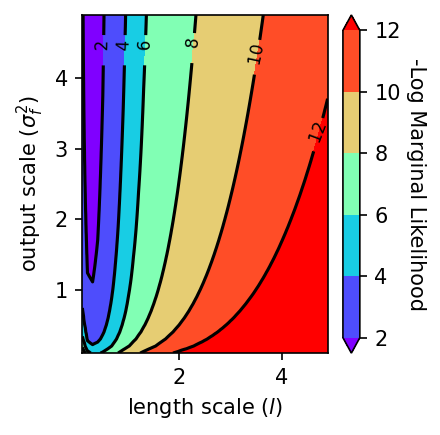

In [9]:
noise_value = 1.0
# Create a list of values ranging from (0.1,0.1) to (4.9,4.9)
scale_and_length = [[i*.1,j*.1] for i in range(1,50) for j in range(1,50)]

x_plt = []
y_plt = []
z_plt = []

for pair in scale_and_length:
    # Initialize 3 hyperparameters
    hypers = {
        'likelihood.noise_covar.noise': torch.tensor(noise_value),
        'covar_module.base_kernel.lengthscale': torch.tensor(pair[0]),
        'covar_module.outputscale': torch.tensor(pair[1]),
    }
    model.initialize(**hypers)
    # Initialize the function for calculating the marginal likelihood log
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    output = model(X_gpr)
    # Call the marginal likelihood log function
    loss = -mll(output, Z_gpr)
    x_plt.append(pair[0])       # Length Scale
    y_plt.append(pair[1])       # Vertical variance (output scale)
    z_plt.append(loss.item())   #-log p

fig = plt.figure(figsize=(3,3), dpi=150)

plt.subplot(1, 1, 1)
ct = plt.tricontour(x_plt, y_plt, z_plt, colors='k')
plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
ct = plt.tricontourf(x_plt, y_plt, z_plt, cmap=plt.cm.rainbow, extend='both')
plt.xlabel("length scale ($l$)")
plt.ylabel("output scale ($σ^2_f$)")
plt.colorbar().set_label("-Log Marginal Likelihood",rotation=270, labelpad=12)
plt.tight_layout()
plt.show()

## Training the Model

Using the previously built class, we can now train the model. We will start with initial values for our hyperparameters and then optimize the hyperparameters until the desired number of iterations is reached. Then we will print the optimized hyperparameters.

In [10]:
model.train()
likelihood.train()

def train_model(model, likelihood, x_train, y_train, print_hp=False):
  hypers = {
      'likelihood.noise_covar.noise': torch.tensor(1.0),
      'covar_module.base_kernel.lengthscale': torch.tensor(1.0),
      'covar_module.outputscale': torch.tensor(1.0),
  }
  model.initialize(**hypers)
  if print_hp:
      # Print untrained hyperparameters
      for param_name, param in model.named_parameters():
        print(f'Parameter name: {param_name:42} value = {param.item():9.5f}')

  training_iter = 100  # using 100 iterations
  # Find optimal model hyperparameters using the SGD optimizer with a learning rate of 0.1
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

  # "Loss" for GPs = -(marginal log likelihood)
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

  for i in range(training_iter):
    # Zero out the gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calculate loss and backpropagation gradients
    loss = -mll(output, y_train)
    loss.backward() # updating the gradients
    if (i+1) % 10 == 0:
      if print_hp:
        print('Iter %3d/%d - Loss: %.3f output scale: %.3f   length scale: %.3f   noise: %.3f' % (
          i + 1, training_iter, loss.item(),
          model.covar_module.outputscale.item(),
          model.covar_module.base_kernel.lengthscale.item(),
          model.likelihood.noise.item()
        ))
        optimizer.step()
  if print_hp:
    # Print Trained hyperparameters
    for param_name, param in model.named_parameters():
      print(f'Parameter name: {param_name:42} value = {param.item():9.5f}')

train_model(model, likelihood, X_gpr, Z_gpr, print_hp=True)

Parameter name: likelihood.noise_covar.raw_noise           value =   0.54117
Parameter name: covar_module.raw_outputscale               value =   0.54132
Parameter name: covar_module.base_kernel.raw_lengthscale   value =   0.54132
Iter  10/100 - Loss: 5.879 output scale: 1.000   length scale: 1.000   noise: 1.000
Iter  20/100 - Loss: 4.263 output scale: 1.046   length scale: 0.787   noise: 1.136
Iter  30/100 - Loss: 3.360 output scale: 1.087   length scale: 0.633   noise: 1.209
Iter  40/100 - Loss: 2.854 output scale: 1.119   length scale: 0.536   noise: 1.250
Iter  50/100 - Loss: 2.479 output scale: 1.149   length scale: 0.459   noise: 1.272
Iter  60/100 - Loss: 2.255 output scale: 1.178   length scale: 0.405   noise: 1.279
Iter  70/100 - Loss: 2.135 output scale: 1.204   length scale: 0.369   noise: 1.279
Iter  80/100 - Loss: 2.063 output scale: 1.230   length scale: 0.345   noise: 1.275
Iter  90/100 - Loss: 2.014 output scale: 1.254   length scale: 0.327   noise: 1.268
Iter 100/100 

### Plotting Predicted, Reference, Difference, and Variance Surfaces

The optimized model can be used to make predictions of the function (energy) at a new input space (configuration), $\,\textbf{x}^*$. Predictions will follow a Gaussian distribution:

$\mathcal{N}\sim(μ^*,\textbf{Σ}^*)$,

where $μ^*=\textbf{K}^{*\mathrm{T}}\tilde{\textbf{K}}^{-1}\textbf{y}$ and $\textbf{Σ}^*=\textbf{K}^{**}-\textbf{K}^\mathrm{*T}\tilde{\textbf{K}}^{-1}\textbf{K}^*$.

In the above equaiton,

$\textbf{K}^*=\textbf{K}(\textbf{X},\textbf{x}^*)$ and $\textbf{K}^{**}=\textbf{K}(\textbf{x}^*,\textbf{x}^*)$

We will use this to plot the GPR predicted surface (Predicted), the analytical surface (Reference), the difference between the predicted and analytical surfaces (Difference), and the variance of the predicted points (Variance).

Min/Max Differences min:  -1194.47233 max:      2.96655
Min/Max Variance    min:      0.08929 max:      1.30226


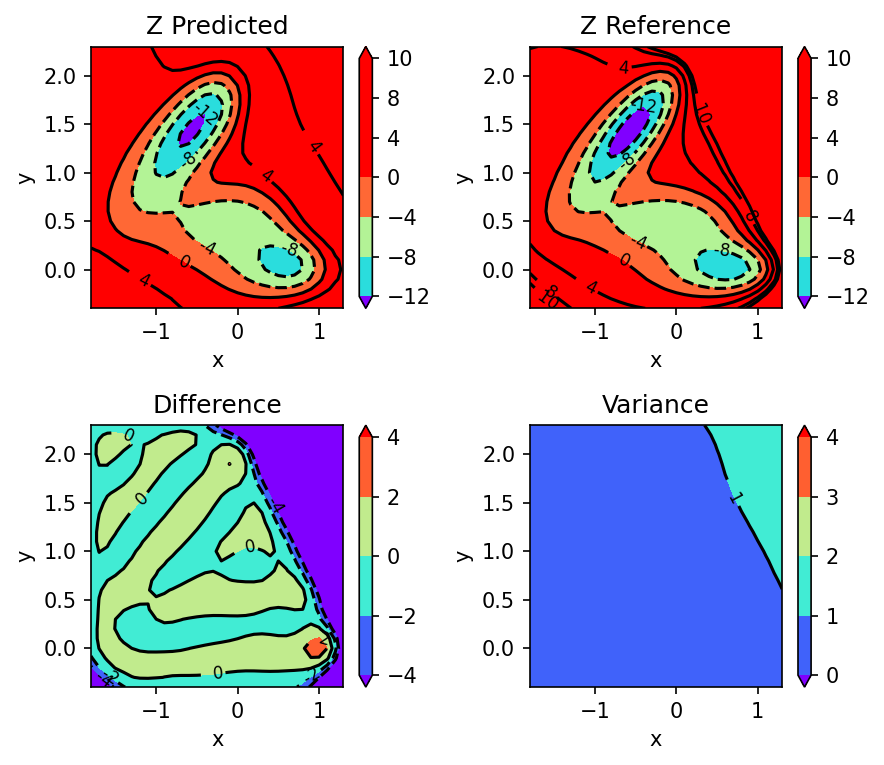

In [11]:
model.eval()
def show_surface(model):
  model.eval()
  z_pred = model(Tensor(xy)).mean
  z_var = model(Tensor(xy)).variance
  Z_pred = np.reshape(z_pred.detach().numpy(),(len(yy),-1))
  Z_var = np.reshape(z_var.detach().numpy(),(len(yy),-1))
  Zdiff = np.subtract(Z_pred, Z)
  fig = plt.figure(figsize=(6,5.2), dpi=150)

  plt.subplot(2, 2, 1)
  levels = [-12, -8, -4, 0, 4, 8, 10]
  ct = plt.contour(X, Y, Z_pred, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z_pred, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("Z Predicted")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(2, 2, 2)
  levels = [-12, -8, -4, 0, 4, 8, 10]
  ct = plt.contour(X, Y, Z, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("Z Reference")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(2, 2, 3)
  levels = [-4, -2, 0, 2, 4]
  ct = plt.contour(X, Y, Zdiff, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Zdiff, levels, cmap=plt.cm.rainbow, extend='both', vmin=-4, vmax=4)
  plt.title("Difference")
  plt.xlabel("x")
  plt.ylabel("y")
  print(f'Min/Max Differences min: {np.amin(Zdiff):12.5f} max: {np.amax(Zdiff):12.5f}')
  plt.colorbar()

  plt.subplot(2, 2, 4)
  levels = [0, 1, 2, 3, 4]
  ct = plt.contour(X, Y, Z_var, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z_var, levels, cmap=plt.cm.rainbow, extend='both', vmin=0, vmax=4)
  plt.title("Variance")
  plt.xlabel("x")
  plt.ylabel("y")
  print(f'Min/Max Variance    min: {np.amin(Z_var):12.5f} max: {np.amax(Z_var):12.5f}')
  plt.colorbar()

  plt.tight_layout()

  plt.show()

show_surface(model)

## Using a GPR model to Predict Energies and Gradients: Defining the Model

Recall the covariance kernel matrix defined in Lesson 2.3:

$\textbf{K(X,X)}=
\begin{bmatrix}
k(\textbf{x}_1,\textbf{x}_1) & \ldots & k(\textbf{x}_1,\textbf{x}_n)\\
\vdots & \ddots & \vdots\\
k(\textbf{x}_n,\textbf{x}_1) & \ldots & k(\textbf{x}_n,\textbf{x}_n)\\
\end{bmatrix}$

where the radial basis functions $k(\textbf{x}_n,\textbf{x}_n)$ are functions of the input feature vectors  $\textbf{x}=[x_1,...,x_D]$

Our input feature vectors are composed into a training set $\textbf{X}=[\textbf{x}_1, ...,\textbf{x}_n]$ with observations $\textbf{y}=[y_1,...,y_n]^T$

Each observation $y(\textbf{x})$ is dependent upon an underlying function, $f(\textbf{x})$, as well as the noise, $\mathit{ε}$.

Derivatives of Gaussian processes, $\frac{\partial f(\textbf{x})}{\partial x}$, are themselves Gaussian processes; consequently, they can be incorporated into the training targets and used to make explicit predictions of the gradient: $ \mathrm{\textbf{y}}_\mathrm{ext}=  \left[y_1,...,y_n,\frac{\partial f(\textbf{x}_1)}{\partial x},...,\frac{\partial f(\textbf{x}_n)}{\partial x},\frac{\partial f(\textbf{x}_1)}{\partial y},...,\frac{\partial f(\textbf{x}_n)}{\partial y}\right]^\mathrm{T}$

To account for the additional observations, the extended kernel is: $\textbf{K}_\mathrm{ext}(\textbf{X,X}')=
\begin{bmatrix}
\textbf{K}(\textbf{X,X}') & \displaystyle\frac{\partial \textbf{K}(\textbf{X,X}')}{\partial \textbf{X}'} \\
\displaystyle\frac{\partial \textbf{K}(\textbf{X,X}')}{\partial \textbf{X}} & \displaystyle\frac{\partial^2 \textbf{K}(\textbf{X,X}')}{\partial \textbf{X} \partial \textbf{X}'}
\end{bmatrix}$

In [12]:
class GPModelWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.RBFKernelGrad(ard_num_dims=2)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

Z_gpr = Tensor(z_truncated)
DX_gpr = Tensor(dx_truncated)
DY_gpr = Tensor(dy_truncated)

Z = Tensor(Z)
DX = Tensor(DX)
DY = Tensor(DY)

X_gpr = Tensor(xy_truncated)
Y_gpr = torch.stack([Z_gpr, DX_gpr, DY_gpr], 1)  # now including gradient observations in our training data
X_test = Tensor(xy)
print(Z.shape, DX.shape, DY.shape)
Y_test = torch.stack([Z.flatten(), DX.flatten(), DY.flatten()], 1)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)  # Value + x-derivative + y-derivative
model = GPModelWithDerivatives(X_gpr, Y_gpr, likelihood)  #now our model uses gradients and energies for training

use_gpu = torch.cuda.is_available()
if use_gpu:
  X_gpr = X_gpr.cuda()
  Y_gpr = Y_gpr.cuda()
  X_test = X_test.cuda()
  Y_test = Y_test.cuda()
  likelihood = likelihood.cuda()
  model = model.cuda()

torch.Size([28, 32]) torch.Size([28, 32]) torch.Size([28, 32])


## Training the Model

Let $\textbf{K}_\textrm{ext}=\textbf{K}_\textrm{ext}(\textbf{X},\textbf{X}')+σ^2_n\textbf{I}$

As in Lesson 2.3.1, the hyperparameters $\Theta = \{σ^2_f, l, \sigma^2_n\}$ are optimized by maximizing the marginal likelihood log function, which now contains our extended kernel and observation set:

$\mathrm{log}\:p(\textbf{y}_\textrm{ext}|\textbf{X},\textbf{Θ})=-\frac{1}{2}\textbf{y}_\textrm{ext}^\mathrm{T}\tilde{\textbf{K}}_\textrm{ext}^{-1}\textbf{y}_\textrm{ext}-\frac{1}{2}\mathrm{log}\:|\tilde{\textbf{K}}_\textrm{ext}|-\frac{n(m+1)}{2}\mathrm{log}\:2\pi $

where $m$ is the number of gradient observations

In [13]:
model.train()
likelihood.train()

def train_model(model, likelihood, x_train, y_train, print_hp=True):
  training_iter = 100  # using 100 iterations
  # Find optimal model hyperparameters using the Adam optimizer with a learning rate of 0.1
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  for i in range(training_iter):
      optimizer.zero_grad()
      output = model(x_train)
      loss = -mll(output, y_train)
      loss.backward()
      if (i+1) % 10 == 0:
        if print_hp:
          print(f'Iter {i+1:>5}/{training_iter:>} - Loss: {loss.item():6.3f} '
          f'outputscale: {model.covar_module.outputscale:6.3f} lengthscales: {model.covar_module.base_kernel.lengthscale.squeeze()[0]:6.3f}'
          f'{model.covar_module.base_kernel.lengthscale.squeeze()[1]:6.3f} noise: {model.likelihood.noise.item():6.3f}')

        optimizer.step()

#Y_gpr is an array of output values and gradients from the Mueller-Brown potential energy function
train_model(model, likelihood, X_gpr, Y_gpr)

Iter    10/100 - Loss: 19.528 outputscale:  0.693 lengthscales:  0.693 0.693 noise:  0.693
Iter    20/100 - Loss: 15.610 outputscale:  0.744 lengthscales:  0.644 0.644 noise:  0.744
Iter    30/100 - Loss: 12.409 outputscale:  0.798 lengthscales:  0.598 0.598 noise:  0.797
Iter    40/100 - Loss:  9.879 outputscale:  0.852 lengthscales:  0.556 0.555 noise:  0.850
Iter    50/100 - Loss:  7.835 outputscale:  0.908 lengthscales:  0.516 0.515 noise:  0.903
Iter    60/100 - Loss:  6.109 outputscale:  0.965 lengthscales:  0.480 0.478 noise:  0.955
Iter    70/100 - Loss:  4.734 outputscale:  1.021 lengthscales:  0.446 0.444 noise:  1.003
Iter    80/100 - Loss:  3.752 outputscale:  1.078 lengthscales:  0.416 0.412 noise:  1.049
Iter    90/100 - Loss:  3.096 outputscale:  1.133 lengthscales:  0.388 0.383 noise:  1.090
Iter   100/100 - Loss:  2.655 outputscale:  1.188 lengthscales:  0.364 0.358 noise:  1.128


### Using the Model to Predict Energies and Gradients

The optimized model can be used to make predictions of both the function and its gradients at a new input space, $\,\textbf{x}^*$. The expected value (E) of the function  at $\,\textbf{x}^*$ is given by:

$\mathrm{E}\left[f(\textbf{x}^*)|\textbf{y}_\mathrm{ext},\textbf{x}^*,\textbf{X},\Theta\right] = \textbf{K}^*_\mathrm{ext}(\textbf{K}_\mathrm{ext}+\sigma^2_\mathrm{n}\textbf{I})^{-1}\textbf{y}_\mathrm{ext}$

where $\textbf{K}^\ast_\mathrm{ext}=\textbf{K}_\mathrm{ext}(\textbf{x}^\ast,\textbf{X})$.

The associated predictive variance (Var) is given by:

$\mathrm{Var}\left[f(\textbf{x}^*)|\textbf{y}_\mathrm{ext},\mathrm{\textbf{x}^\ast},\mathrm{\textbf{X}},\Theta\right] = k(\mathrm{\textbf{x}^\ast},\mathrm{\textbf{x}^\ast})-\textbf{K}^\ast_\mathrm{ext}(\textbf{K}_\mathrm{ext}+\sigma^2_\mathrm{n}\textbf{I})^{-1}\textbf{K}^{\ast\mathrm{T}}_\mathrm{ext}$

The predictions of the expected gradients are given by:

$\mathrm{E}\left[\frac{\partial f(\mathrm{\textbf{x}^\ast})}{\partial q}\bigg|\mathrm{\textbf{y}}_\mathrm{ext},\mathrm{\textbf{x}^\ast},\mathrm{\textbf{X}},\Theta\right] = \frac{\partial \textbf{K}^\ast_\mathrm{ext}}{\partial q}(\textbf{K}_\mathrm{ext}+\sigma^2_\mathrm{n}\textbf{I})^{-1}\textbf{y}_\mathrm{ext}$

where $q$ corresponds to the input ($x$ or $y$). The associated variances are given by:

$\mathrm{Var}\left[\frac{\partial f(\mathrm{\textbf{x}^\ast})}{\partial q}\bigg|\mathrm{\textbf{y}}_\mathrm{ext},\mathrm{\textbf{x}^\ast},\mathrm{\textbf{X}},\Theta\right] =\frac{\partial^2 k(\mathrm{\textbf{x}^\ast},\mathrm{\textbf{x}^\ast})}{\partial q^2}-\frac{\partial \textbf{K}^\ast_\mathrm{ext}}{\partial q}(\textbf{K}_\mathrm{ext}+\sigma^2_\mathrm{n}\textbf{I})^{-1}\frac{\partial \textbf{K}^{\ast\mathrm{T}}_\mathrm{ext}}{\partial q}$


In [14]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_computations(log_prob=False, covar_root_decomposition=False):
    predictions = likelihood(model(X_test))
    mean = predictions.mean

### Plotting Predicted and Reference Surfaces and Gradients

We can now plot the reference and GPR predicted energies and gradients.

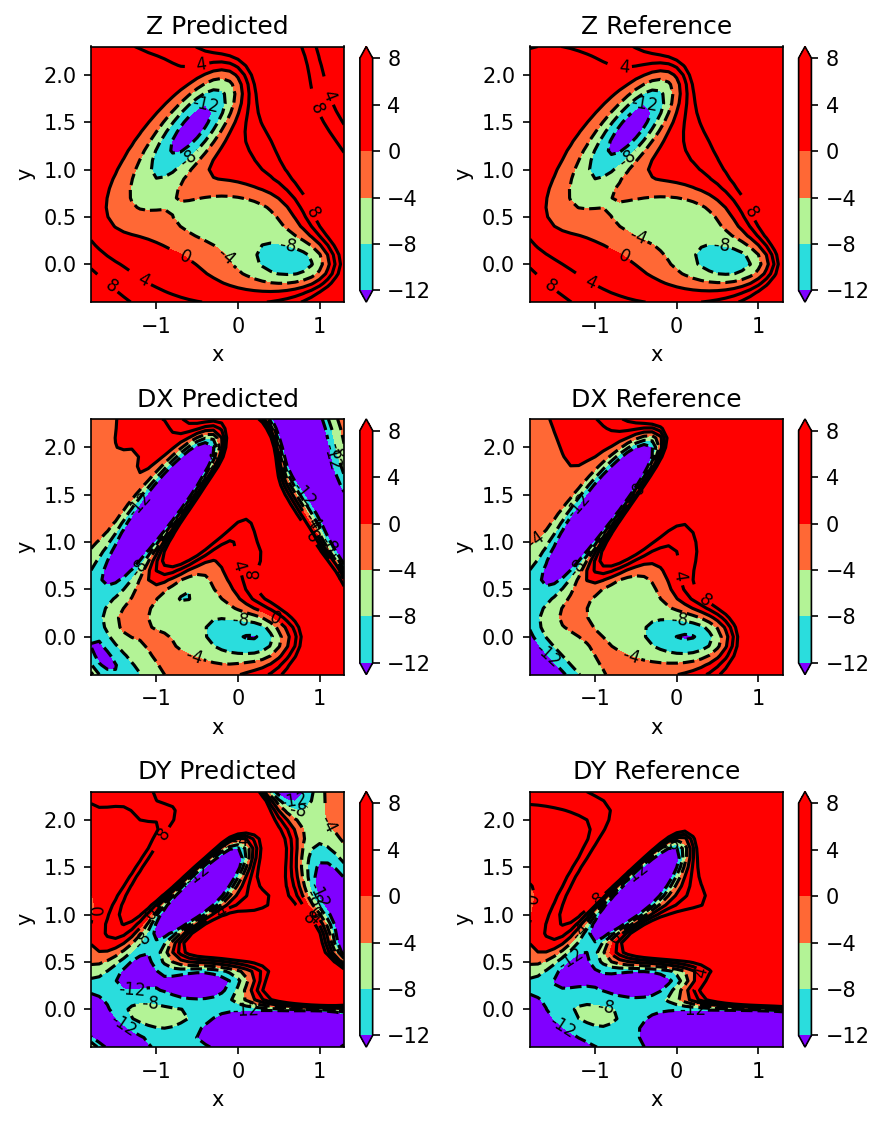

In [15]:
if use_gpu:
  mean = mean.cpu()

def show_surface():
  n1, n2 = 896, 1
  z_pred = mean[:, 0]
  Z_pred = np.reshape(z_pred.detach().numpy(),(len(yy),-1))
  Zdiff = np.subtract(Z_pred, Z)
  dx_pred = mean[:, 1]
  DX_pred = np.reshape(dx_pred.detach().numpy(),(len(yy),-1))
  DX_diff = np.subtract(DX_pred, DX)
  dy_pred = mean[:, 2]
  DY_pred = np.reshape(dy_pred.detach().numpy(),(len(yy),-1))
  DY_diff = np.subtract(DY_pred, DY)

  fig = plt.figure(figsize=(6,7.6), dpi=150)

  plt.subplot(3, 2, 1)
  levels = [-12, -8, -4, 0, 4, 8]
  ct = plt.contour(X, Y, Z_pred, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z_pred, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("Z Predicted")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(3, 2, 2)
  levels = [-12, -8, -4, 0, 4, 8]
  ct = plt.contour(X, Y, Z, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("Z Reference")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(3, 2, 3)
  levels = [-12, -8, -4, 0, 4, 8]
  ct = plt.contour(X, Y, DX_pred, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, DX_pred, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("DX Predicted")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(3, 2, 4)
  levels = [-12, -8, -4, 0, 4, 8]
  ct = plt.contour(X, Y, DX, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, DX, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("DX Reference")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(3, 2, 5)
  levels = [-12, -8, -4, 0, 4, 8]
  ct = plt.contour(X, Y, DY_pred, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, DY_pred, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("DY Predicted")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.subplot(3, 2, 6)
  levels = [-12, -8, -4, 0, 4, 8]
  ct = plt.contour(X, Y, DY, levels, colors='k')
  plt.clabel(ct, inline=True, fmt='%3.0f', fontsize=8)
  ct = plt.contourf(X, Y, DY, levels, cmap=plt.cm.rainbow, extend='both', vmin=-15, vmax=0)
  plt.title("DY Reference")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.colorbar()

  plt.tight_layout()
  plt.show()

show_surface()

## Model Performance and Training Set Size

Now that our model works, we can look at how the size of our training set changes the accuracy of our model. Below you can see that as the size of the training set increases, the root-mean square error (RMSE) decreases and the $R^2$ increases.

In [16]:
import tabulate

X_gpr = Tensor(xy_truncated)
Z_gpr = Tensor(z_truncated)

X_test = X_gpr.detach()
Z_test = Z_gpr.detach()
def evaluate_model(train_x, train_z, test_x, test_z, model):
  model.eval()
  preds_train = model(train_x).mean
  preds_test = model(test_x).mean
  rmse_train = torch.sqrt((torch.mean(train_z - preds_train)**2))
  rmse_test = torch.sqrt((torch.mean(test_z - preds_test)**2))
  r2 = 1 - torch.sum((train_z-preds_train)**2)/torch.sum((train_z-torch.mean(train_z))**2)
  q2 = 1 - torch.sum((train_z-preds_train)**2)/torch.sum((train_z-torch.mean(train_z))**2)
  return rmse_train, r2, rmse_test, q2

def reduce_training_set(train_x, train_z, new_size):
  arr_index = np.arange(train_z.shape[0])
  np.random.shuffle(arr_index)
  return train_x[arr_index[:new_size],:], train_z[arr_index[:new_size]]

def new_model(train_x, train_z):
  likelihood = gpytorch.likelihoods.GaussianLikelihood()
  model = ExactGPModel(train_x, train_z, likelihood)
  model.train()
  likelihood.train()
  train_model(model, likelihood,X_gpr, Z_gpr, print_hp=False)
  return model

size_list = []
rmse_train_list = []
r2_list = []
rmse_test_list = []
q2_list = []

training_set_sizes = [696, 600, 500, 400, 300, 200, 100]
for set_size in training_set_sizes:
  X_gpr, Z_gpr = reduce_training_set(X_gpr, Z_gpr, set_size)
  model = new_model(X_gpr, Z_gpr)
  rmse_train, r2, rmse_test, q2 = evaluate_model(X_gpr, Z_gpr, X_test, Z_test, model)
  size_list.append(set_size)
  rmse_train_list.append(rmse_train)
  r2_list.append(r2)
  rmse_test_list.append(rmse_test)
  q2_list.append(q2)

training_set_dict = {
    'Training Set Size': size_list,
    'Training Set RMSE': rmse_train_list,
    'R^2': r2_list,
    'Testing Set RMSE': rmse_test_list,
    'Q^2': q2_list
}

print(tabulate.tabulate(training_set_dict, headers = 'keys', floatfmt="9.4f"))

/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning:

The input matches the stored training data. Did you forget to call model.train()?



  Training Set Size    Training Set RMSE        R^2    Testing Set RMSE        Q^2
-------------------  -------------------  ---------  ------------------  ---------
                696               0.0466     0.9756              0.0466     0.9756
                600               0.0512     0.9720              0.0715     0.9720
                500               0.0562     0.9681              0.1011     0.9681
                400               0.0657     0.9634              0.1196     0.9634
                300               0.0814     0.9536              0.1180     0.9536
                200               0.1023     0.9441              0.1344     0.9441
                100               0.0997     0.9207              0.2493     0.9207


### Comparing Kernels

Now we can compare GPR results using a different kernel. Before we used the RBF kernel, but now we can compare the performance of the RBF kernel with the Matern and Rational Quadratic (RQ) kernels.

In [17]:
# Setup GPR Model: Taken directly From gpytorch tutorial with minor changes
class GPModel_kernel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_Z, likelihood, kernel):
        super().__init__(train_x, train_Z, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

X_gpr = Tensor(xy_truncated)
Z_gpr = Tensor(z_truncated)

kernels = [
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel()),
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
]

def train_model_k(model, likelihood):
  training_iter = 100
  # Use the SGD optimizer
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X_gpr)
    # Calc loss and backprop gradients
    loss = -mll(output, Z_gpr)
    loss.backward()
    optimizer.step()

for kernel in kernels:
  # Initialize Likelihood and Model
  likelihood = gpytorch.likelihoods.GaussianLikelihood()
  model = GPModel_kernel(X_gpr, Z_gpr, likelihood, kernel)
  model.train()
  likelihood.train()
  train_model_k(model, likelihood)
  rmse_train, r2, rmse_test, q2 = evaluate_model(X_gpr, Z_gpr, X_test, Z_test, model)
  kernel_name = str(kernel.base_kernel).split('(')
  #Print the kernel we are running above the rmse_train output.
  print(f'Kernel: {kernel_name[0]}')
  print(f'RMSE:   {rmse_train.item():>6.4f}')

Kernel: RBFKernel
RMSE:   0.0031
Kernel: MaternKernel
RMSE:   0.0026
Kernel: RQKernel
RMSE:   0.0021
